# Amazon Product Recommender
> Applying product title descriptions based text semantic methods to recommend similar products

- toc: true
- badges: true
- comments: true
- categories: [Retail, Word2Vec, Visualization, TFIDF, AmazonData]
- author: "<a href='https://github.com/ShrishailK/Amazon-recommendation-engine'>ShrishailK</a>"
- image:

## Download the data

In [1]:
# !pip install -q -U kaggle
# !pip install --upgrade --force-reinstall --no-deps kaggle
# !mkdir ~/.kaggle
# !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d ajaysh/women-apparel-recommendation-engine-amazoncom

In [12]:
!unzip /content/women-apparel-recommendation-engine-amazoncom.zip

Archive:  /content/women-apparel-recommendation-engine-amazoncom.zip
  inflating: tops_fashion.json       


## Setup

In [35]:
import numpy as np
import pandas as pd
import itertools
import math
import scipy.sparse
from collections import Counter
from sklearn import preprocessing

import re
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import requests
from PIL import Image
from io import BytesIO

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec

import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances

In [2]:
nltk.download('stopwords')
stopword = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data loading

In [53]:
data = pd.read_json('tops_fashion.json')
data.shape

(183138, 19)

In [54]:
data.head()

,sku,asin,product_type_name,formatted_price,author,color,brand,publisher,availability,reviews,large_image_url,availability_type,small_image_url,editorial_review,title,model,medium_image_url,manufacturer,editorial_reivew
0,None,B016I2TS4W,SHIRT,None,None,None,FNC7C,None,None,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,Minions Como Superheroes Ironman Women's O Nec...,Minions Como Superheroes Ironman Long Sleeve R...,None,https://images-na.ssl-images-amazon.com/images...,None,NaN
1,None,B01N49AI08,SHIRT,None,None,None,FIG Clothing,None,None,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,Sizing runs on the small side. FIG® recommends...,FIG Clothing Womens Izo Tunic,None,https://images-na.ssl-images-amazon.com/images...,None,NaN
2,None,B01JDPCOHO,SHIRT,None,None,None,FIG Clothing,None,None,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,Sizing runs on the small side. FIG® recommends...,FIG Clothing Womens Won Top,None,https://images-na.ssl-images-amazon.com/images...,None,NaN
3,None,B01N19U5H5,SHIRT,None,None,None,Focal18,None,None,"[True, https://www.amazon.com/reviews/iframe?a...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,100% Brand New & Fashion<br> Quantity: 1 Piece...,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...,None,https://images-na.ssl-images-amazon.com/images...,None,NaN
4,None,B004GSI2OS,SHIRT,$26.26,None,Onyx Black/ Stone,FeatherLite,None,Usually ships in 6-10 business days,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,now,https://images-na.ssl-images-amazon.com/images...,,Featherlite Ladies' Long Sleeve Stain Resistan...,None,https://images-na.ssl-images-amazon.com/images...,None,NaN


In [55]:
# keeping just the pertinent features
data = data[['asin','product_type_name', 'formatted_price','title','medium_image_url']]

## Exploration

In [56]:
data.dtypes

asin                 object
product_type_name    object
formatted_price      object
title                object
medium_image_url     object
dtype: object

In [57]:
data.memory_usage(deep=True)  # memory usage in bytes

Index                     128
asin                 12270246
product_type_name    11455348
formatted_price       5497912
title                21603054
medium_image_url     23670528
dtype: int64

In [58]:
data.describe()

,asin,product_type_name,formatted_price,title,medium_image_url
count,183138,183138,28395,183138,183138
unique,183138,72,3135,175985,170782
top,B01D936ANU,SHIRT,$19.99,Nakoda Cotton Self Print Straight Kurti For Women,https://images-na.ssl-images-amazon.com/images...
freq,1,167794,945,77,23


In [59]:
data.describe(include=['O'])

,asin,product_type_name,formatted_price,title,medium_image_url
count,183138,183138,28395,183138,183138
unique,183138,72,3135,175985,170782
top,B01D936ANU,SHIRT,$19.99,Nakoda Cotton Self Print Straight Kurti For Women,https://images-na.ssl-images-amazon.com/images...
freq,1,167794,945,77,23


In [60]:
#Basic stats for product type
print('The basic statistics for product type on amazon are as follows: \n{}\n\n'.format(data['product_type_name'].describe()))

#product type segregation
print('Product type count:\n{}\n\n'.format(Counter(list(data['product_type_name'])).most_common(10)))

#basic stats for titles
print('The basic statistics for product ttiles on amazon are as follows: \n{}\n\n'.format(data['title'].describe()))

#Basic stats for product type
print('{} % of the total points have a listed price \n \n'.format(data[~data['formatted_price'].isnull()].shape[0]/data.shape[0]*100))

The basic statistics for product type on amazon are as follows: 
count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object


Product type count:
[('SHIRT', 167794), ('APPAREL', 3549), ('BOOKS_1973_AND_LATER', 3336), ('DRESS', 1584), ('SPORTING_GOODS', 1281), ('SWEATER', 837), ('OUTERWEAR', 796), ('OUTDOOR_RECREATION_PRODUCT', 729), ('ACCESSORY', 636), ('UNDERWEAR', 425)]


The basic statistics for product ttiles on amazon are as follows: 
count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object


15.504701372735314 % of the total points have a listed price 
 



## Data cleaning

In [66]:
# data.memory_usage(deep=True)  # memory usage before encoding

# # convert "product type" column data type to category
# data["product_type_name"] = data["product_type_name"].astype("category")

# # label encode the "asin" column
# # because it is currently in object form, and taking lots of storage memory
# le_asin = preprocessing.LabelEncoder()
# data.loc[:,"asin"] = le_asin.fit_transform(data["asin"].values)

# # label encode the "url" column also
# le_url = preprocessing.LabelEncoder()
# data.loc[:,"medium_image_url"] = le_url.fit_transform(data["medium_image_url"].values)

# # convert "price" column to float
# data.loc[:,"formatted_price"] = data["formatted_price"].replace('Too low to display', None)
# data.loc[:,"formatted_price"] = data["formatted_price"].replace('[\$,]', '', regex=True).astype(float)

# data.memory_usage(deep=True)  # memory usage after encoding

In [62]:
# removing products without a price as we need a price to sell products
data = data[~data['formatted_price'].isnull()]
print('The number of products (data points) remaining after removing products without a price: \n{}\n'.format(data.shape[0]))


#removing products without a title as we need titles for vectorization
#distance based similarity recommendation for title vectorization
data = data[~data['title'].isnull()]
print('The number of products (data points) remaining after removing products without a title description required for vectorization:\n{}\n'.format(data.shape[0]))


#removing products with small length titles as they might not adequately describe product
data = data[data['title'].apply(lambda x : len(x.split())>4)]
print('The number of products (data points) remaining after removing products with insufficient title descriptions required for vectorization:\n{}\n'.format(data.shape[0]))  

The number of products (data points) remaining after removing products without a price: 
28395

The number of products (data points) remaining after removing products without a title description required for vectorization:
28395

The number of products (data points) remaining after removing products with insufficient title descriptions required for vectorization:
27958



In [63]:
#removing stopwords, terms which are not alphanumeric and lowering text
def text_clean(txt):
  txt = re.sub('[^A-Za-z0-9]+', ' ', txt)
  txt = txt.lower()
  pattern = re.compile(r'\b(' + r'|'.join(stopword) + r')\b\s*')
  txt = pattern.sub(' ', txt)
  txt = ' '.join(txt.split())
  return txt

In [29]:
x = data.sample(5).title.values
x

array(['Free People Womens Break of Dawn Criss-Cross Back Oversized Tank Top Purple XS',
       "Women's The New Riders Of The Purple Sage Long Sleeve T-Shirt",
       "Nimbus Women's Augusta feminine elegance tunic - Light Blue - M",
       'Entro Womens Printed Peplum Top (Navy )',
       "Guns N' Roses Popular Card Tee Shirt for Pretty Lady XXL Red"],
      dtype=object)

In [30]:
[text_clean(_x) for _x in x]

['free people womens break dawn criss cross back oversized tank top purple xs',
 'women new riders purple sage long sleeve shirt',
 'nimbus women augusta feminine elegance tunic light blue',
 'entro womens printed peplum top navy',
 'guns n roses popular card tee shirt pretty lady xxl red']

In [64]:
data['title'] = data['title'].apply(text_clean)

In [65]:
data.head()

,asin,product_type_name,formatted_price,title,medium_image_url
4,B004GSI2OS,SHIRT,$26.26,featherlite ladies long sleeve stain resistant...,https://images-na.ssl-images-amazon.com/images...
6,B012YX2ZPI,SHIRT,$9.99,women unique 100 cotton special olympics world...,https://images-na.ssl-images-amazon.com/images...
11,B001LOUGE4,SHIRT,$11.99,ladies cotton tank 2x1 ribbed tank top,https://images-na.ssl-images-amazon.com/images...
15,B003BSRPB0,SHIRT,$20.54,featherlite ladies moisture free mesh sport sh...,https://images-na.ssl-images-amazon.com/images...
21,B014ICEDNA,SHIRT,$7.50,supernatural chibis sam dean castiel short sle...,https://images-na.ssl-images-amazon.com/images...


In [ ]:
#Downloading Googles Word2Vec library to be used in all word to vec models using a pretrained model by google
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
!gzip -d GoogleNews-vectors-negative300.bin.gz

modl = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

#vocab = stores all the words in google Word2vec model
vocab = modl.vocab

In [45]:
#Utility function for results 
def display_img(url):
    #Get url of the product and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)

def heatmap_image(keys,values,labels,url,text):
    #keys gives the list of words for recommended title
    #divide the figure into two parts
    
    gs = gridspec.GridSpec(1,2,width_ratios = [4,1])
    fg = plt.figure(figsize=(25,3))
    
    #1st figure plotting a heatmap that represents the most commonly occuring words
    ax = plt.subplot(gs[0])
    ax = sns.heatmap(np.array([values]),annot=np.array([labels]))
    ax.set_xticklabels(keys)
    ax.set_title(text)                 
    
    #2nd figure plotting a heatmap that represents the image of the product
    ln = plt.subplot(gs[1])
    ln.set_xticks([])
    ln.set_yticks([])
    
    fig = display_img(url)
    
    #display combine figure
    plt.show()

def heatmap_image_plot(doc_id,vec1,vec2,url,text,model,tfidf_title_vectorizer,tfidf_title_features,idf_title_vectorizer,idf_title_features):
    
                     
    intersection = set(vec1.keys()) & set(vec2.keys())
    
    #set the value of non intersecting word to zero in vec2                 
    for i in vec2.keys():
        if i not in intersection:
            vec2[i]=0
    #if ith word in intersection(list of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0                 
    values = [vec2[x] for x in vec2.keys()]
    
    #labels for heatmap
    keys = list(vec2.keys())
                     
    if model == 'bag_of_words':
        labels = values
    
    elif model == 'Tfidf':
        labels = []
        for i in vec2.keys():
            if i in tfidf_title_vectorizer.vocabulary_:
                #idf_title_vectorizer.vocabulary contains all the words in the corpus         
                labels.append(tfidf_title_features[doc_id,tfidf_title_vectorizer.vocabulary_[i]])
        
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for i in vec2.keys():
            if i in idf_title_vectorizer.vocabulary_:
                #idf_title_vectorizer.vocabulary contains all the words in the corpus         
                labels.append(idf_title_features[doc_id,idf_title_vectorizer.vocabulary_[i]])
        
            else:
                labels.append(0)
                     
    heatmap_image(keys,values,labels,url,text)
                     
                     
def text_vector(sentence):
    words = sentence.split()    
    return Counter(words)


def visualization(doc_id,sentence1,sentence2,url,model,tfidf_title_vectorizer,tfidf_title_features,idf_title_vectorizer,idf_title_features):
    vec1 = text_vector(sentence1)
    vec2 = text_vector(sentence2)
                     
    heatmap_image_plot(doc_id,vec1,vec2,url,sentence2,model,tfidf_title_vectorizer,tfidf_title_features,idf_title_vectorizer,idf_title_features)  

In [46]:
#utility function to better visualize and understand results

def get_word_vec(sentence,doc_id,model_name,idf_title_vectorizer,idf_title_features):
    #doc_id : index id in vectorized array
    #sentence : title of product
    #model_name : 'avg', we will append the model[i], w2v representation of word i
    
    vec = []
    for i in sentence.split():
        if i in vocab:
            if model_name == 'avg':
                vec.append(modl[i])
            elif model_name == 'weighted' and i in idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id,idf_title_vectorizer.vocabulary_[i]] * modl[i] )
        else:
            vec.append(np.zeros(shape=(300,)))
    return np.array(vec)
def get_distance(vec1,vec2):
    # vec1 = np.array(#number_of_words_title1 * 300), each row is a vector of length 300 corresponds to each word in give title
    # vec2 = np.array(#number_of_words_title2 * 300), each row is a vector of length 300 corresponds to each word in give title
    final_dist = []
    for i in vec1:
        dist = []
        for j in vec2:
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
            
    return np.array(final_dist)

def results_Word2Vec(sentence1,sentence2,url,doc_id1,doc_id2,model_name,idf_title_vectorizer,idf_title_features):
    # sentence1 : title1, input product
    # sentence2 : title2, recommended product
    # model:  'avg'

    sentence_vec1 = get_word_vec(sentence1,doc_id1,model_name,idf_title_vectorizer,idf_title_features)
    sentence_vec2 = get_word_vec(sentence2,doc_id2,model_name,idf_title_vectorizer,idf_title_features)
    
    #sent1_sent2_dist = eucledian distance between i and j
    #sent1_sent2_dist = np array with dimensions(#number of words in title1 * #number of words in title2)
    sent1_sent2_dist = get_distance(sentence_vec1,sentence_vec2)
    
    # divide whole figure into 2 parts 1st part displays heatmap 2nd part displays image of products
    
    gs = gridspec.GridSpec(1,2,width_ratios=[4,1])
    fg = plt.figure(figsize=(15,15))
    
    ax = plt.subplot(gs[0])
    ax = sns.heatmap(np.round(sent1_sent2_dist,3), annot = True)
    ax.set_xticklabels(sentence2.split())
    # set the y axis labels as input product title
    ax.set_yticklabels(sentence1.split())
    # set title as recommended product title
    ax.set_title(sentence2)
    
    #setting the fontsize and rotation of x tick tables
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 12,rotation=90)
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 12,rotation=45)
    
    fg = plt.subplot(gs[1])
    fg.set_xticks([])
    fg.set_yticks([])
    fig = display_img(url)
    
    #display combine figure
    plt.show()   

In [47]:
#define additional functions needed for IDF vectorization
def containing(word, df):
    #returns the number of documents which have the word
    return sum(1 for sentence in df['title'] if word in sentence.split())

def idf(word, df):
    #return the idf value for a word
    return math.log(df.shape[0]/(containing(word,df))) 

In [75]:
#define additional functions needed for avg and weighted Word2Vec vectorization
#Function for Word2Vec vectorization
#perform Word2Vec vectorization in advance to use the vectorized array directly in distance based similarity recommendation
#as performing Word2Vec vectorization each time is computationally intensive compared to Bag of words and idf based vectorization.

def avg_word_vec(sentence,no_features,id_=0,model_name='avg',idf_title_vectorizer=0,idf_title_features=0):
    
    # sentence: title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
    # model_name: model information
    # if  model_name == 'avg', add the value model[i], w2v representation of word i
    # if mode_name ='weighted' add the value idf_title_features[doc_id,idf_title_vectorizer[word]] * model[word]
    # idf_title_vectorizer : 0 for 'avg' and idf vectorized array for 'weighted'  
    # idf_title_features : 0 for 'avg' and idf vectorized array for 'weighted'
    
    featureVec = np.zeros(shape=(300,), dtype="float32")
    # initialize a vector of size 300 with all zeros
    # add each word2vec(wordi) to this fetureVec

    ncount = 0
    for word in sentence.split():
        ncount += 1
        if word in vocab:
            if model_name == 'avg':
                featureVec = np.add(featureVec,modl[word])
            elif model_name == 'weighted' and word in idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, modl[word] * idf_title_features[id_,idf_title_vectorizer.vocabulary_[word]])
        if (ncount>0):
            featureVec = np.divide(featureVec,ncount)

    #return avg vec
    return featureVec  

In [76]:
def Vectorization(data,model):
  #data : Data set containing text data
  #model : method used for text vectorization

  if model == 'bag_of_words':
      #Vectorization using Bag of words
      title_vectorizer = CountVectorizer()
      title_features = title_vectorizer.fit_transform(data['title'])   
      return title_features,title_vectorizer

  elif model == 'Tfidf':
      #Vectorization using tfidfVectorizer
      tfidf_title_vectorizer = TfidfVectorizer()
      tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])
      return tfidf_title_features,tfidf_title_vectorizer
  
  elif model == 'idf':
      #Vectorization using idf function
      idf_title_vectorizer = CountVectorizer()
      idf_title_features = idf_title_vectorizer.fit_transform(data['title'])
      
      #converting all the values into float
      idf_title_features = idf_title_features.astype(np.float)

      #assigning df value for idf[value] function
      df = data.copy()

      for i in idf_title_vectorizer.vocabulary_.keys():
          idf_value = idf(i,df)
          #j is the index of the nonzero values
          for j in idf_title_features[:,idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
              idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_value
  
      scipy.sparse.save_npz('idf_title_features.npz', idf_title_features)

      return idf_title_features,idf_title_vectorizer
  
  elif model == 'avg':
      w2vec_title_features = []
      #building vector for each title 
      for i in data['title']:
          w2vec_title_features.append(avg_word_vec(i,300))

      #w2v_title_features = np.array(# number of doc/rows in courpus * 300) 
      Word2Vec_features = np.array(w2vec_title_features)

      #saving dataframe in a npz file
      np.savez_compressed("Word2Vec_aveg.npz",Word2Vec_features)
      
      return Word2Vec_features
  
  elif model == 'weighted':
      #Load the saved idf vectorized sparse array .npz
      #title_features= Vectorization(data,'idf')
      idf_title_features = scipy.sparse.load_npz('idf_title_features.npz') #OR we can Vectorize using the code above

      #to get the words in columns implement count vectorizers
      idf_title_vectorizer = CountVectorizer()
      vectorizer = idf_title_vectorizer.fit_transform(data['title'])

      id_ = 0 
      w2vec_title_weight = []

      #building vector for each title
      for i in data['title']:
          w2vec_title_weight.append(avg_word_vec(i,300,id_,'weighted',idf_title_vectorizer = idf_title_vectorizer ,idf_title_features = idf_title_features))
          id_ += 1

      #w2v_title_weight = np.array(# number of doc/rows in courpus * 300) 
      w2vec_title_weight = np.array(w2vec_title_weight)

      #saving dataframe in a npz file
      np.savez_compressed("Word2Vec_weighted.npz",w2vec_title_weight)

      return w2vec_title_weight

In [ ]:
_, _ = Vectorization(data, model='idf')

> Note: Storing the vectorization array as a .npz file because performing Avg Word2Vec vectorization each time is computationally expensive for Word2Vec

In [77]:
%%time
_ = Vectorization(data, model='avg')

CPU times: user 4.2 s, sys: 365 ms, total: 4.56 s
Wall time: 4.19 s


In [78]:
%%time
_ = Vectorization(data, model='weighted')

CPU times: user 11.8 s, sys: 794 ms, total: 12.6 s
Wall time: 11.8 s


In [50]:
def distance_similarity(doc_id, data, model, cut_off):
  #data : data contaning text for vectorization 
  #model : method used for text vectorization
  #Cut_off : the number of recommendations we give out
  #df :  data set used to retrieve orignal movie description and genre
  
  if model == 'bag_of_words':  
      title_features,title_vectorizer = Vectorization(data,model)

      #doc_id is id on the new index formed after CountVectorizer is applied to the data['title']
      #pairwise distances saves the distance between given input product and all other products
      pairwise_dist = pairwise_distances(title_features,title_features[doc_id],metric = 'cosine')

      #np.argsort returns indices of the smallest distances
      indices = np.argsort(pairwise_dist.flatten())[:cut_off]

      #get the index id of product in the original dataframe
      data_indices = list(data.index[indices])
      
      for i in range(0,len(data_indices)):
          visualization(indices[i], data['title'].loc[data_indices[0]], data['title'].loc[data_indices[i]], data['medium_image_url'].loc[data_indices[i]], 'bag_of_words',tfidf_title_vectorizer = 0,tfidf_title_features = 0, idf_title_vectorizer = 0,idf_title_features = 0)
          print('The amazon ID of the apparel is {}'.format(data['asin'].loc[data_indices[i]]))

  elif model == 'Tfidf':
      #storing array after vectorization
      tfidf_title_features,tfidf_title_vectorizer = Vectorization(data,model)

      #doc_id is the id in the new index formed after CountVectorizer is applied to the data['title']
      #pairwise distance saves the distance between given input product and all other products
      pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id],metric = 'cosine')

      #np.argsort returns indices of the smallest distances
      indices = np.argsort(pairwise_dist.flatten())[:cut_off]

      #get the index id of product in the original dataframe
      data_indices = list(data.index[indices])

      for i in range(0,len(data_indices)):
          visualization(indices[i], data['title'].loc[data_indices[0]], data['title'].loc[data_indices[i]], data['medium_image_url'].loc[data_indices[i]], 'Tfidf',tfidf_title_vectorizer,tfidf_title_features ,idf_title_vectorizer=0,idf_title_features=0)
          print('The amazon ID of the apparel is {}'.format(data['asin'].loc[data_indices[i]]))
          
  elif model == 'idf':
      #do not use vectorizer as it is computationally expensive to vectorize everytime
      #Load the saved vectorized sparse array .npz
      #title_features= Vectorization(data,'idf')
      idf_title_features = scipy.sparse.load_npz('idf_title_features.npz') #OR we can Vectorize using the code above
      
      idf_title_features = idf_title_features.toarray()
      
      #to get the words in columns implement count vectorizers
      idf_title_vectorizer = CountVectorizer()
      vectorizer = idf_title_vectorizer.fit_transform(data['title'])

      #doc_id is the id in the new index formed after CountVectorizer is applied to the data['title']
      #pairwise distance will save the distance between given input product and all other products
      pairwise_dist = pairwise_distances(idf_title_features,idf_title_features[doc_id].reshape(1,-1),metric = 'cosine')

      #np.argsort will return indices of the smallest distances
      indices = np.argsort(pairwise_dist.flatten())[:cut_off]

      #get the index id of product in the original dataframe
      data_indices = list(data.index[indices])

      for i in range(0,len(data_indices)):
          visualization(indices[i], data['title'].loc[data_indices[0]], data['title'].loc[data_indices[i]], data['medium_image_url'].loc[data_indices[i]], 'idf', tfidf_title_vectorizer=0, tfidf_title_features=0, idf_title_vectorizer = idf_title_vectorizer, idf_title_features = idf_title_features)
          print('The amazon ID of the apparel is {}'.format(data['asin'].loc[data_indices[i]]))
  
  elif model == 'avg':
      #Word2Vec_features = Vectorization(data['title'],'avg')
      #do not use vectorizer as it is computationally expensive to vectorize everytime 
      #Load the stored vectorized array .npz
      Word2Vec_features = np.load("Word2Vec_aveg.npz")
                
      #uncompresing npz to numpy array array
      Word2Vec_features  = Word2Vec_features['arr_0']

      #doc_id is the id of the product in the new index formed after CountVectorizer is applied to the data['title']
      #pairwise distance will save the distance between given input product and all other products
      pairwise_dist = pairwise_distances(Word2Vec_features,Word2Vec_features[doc_id].reshape(1,-1))

      #np.argsort will return indices of the smallest distances
      indices = np.argsort(pairwise_dist.flatten())[:cut_off]

      #get the index id of product in the original dataframe
      data_indices = list(data.index[indices])

      for i in range(0,len(data_indices)):
          results_Word2Vec(data['title'].loc[data_indices[0]], data['title'].loc[data_indices[i]], data['medium_image_url'].loc[data_indices[i]], indices[0], indices[i],'avg',idf_title_vectorizer = 0,idf_title_features = 0)
          print('The amazon ID of the apparel is {}'.format(data['asin'].loc[data_indices[i]]))
                
  elif model == 'weighted':
      #do not use vectorizer as it is computationally expensive to vectorize everytime
      #Load the saved vectorized sparse array .npz
      #title_features= Vectorization(data,'weighted')
      idf_title_features = scipy.sparse.load_npz('idf_title_features.npz') #OR we can Vectorize using the code above
      
  
      #to get the words in columns CountVectorizer
      idf_title_vectorizer = CountVectorizer()
      vectorizer = idf_title_vectorizer.fit_transform(data['title'])

      #Word2Vec_features = Vectorization(data['title'],'avg')
      #do not use vectorizer as it is computationally expensive to vectorize everytime 
      #Load the stored vectorized array .npz
      Word2Vec_features = np.load("Word2Vec_weighted.npz") #OR we can Vectorize using the code above

      #uncompresing npz to numpy array array
      Word2Vec_feature  = Word2Vec_features['arr_0']

      #doc_id is the id in the new index formed after CountVectorizer is applied to the data['title']
      #pairwise distance will save the distance between given input product and all other products
      pairwise_dist = pairwise_distances( Word2Vec_feature, Word2Vec_feature[doc_id].reshape(1,-1))

      #np.argsort will return indices of the smallest distances
      indices = np.argsort(pairwise_dist.flatten())[:cut_off]

      #get the index of the original dataframe
      data_indices = list(data.index[indices])

      for i in range(0,len(data_indices)):
          results_Word2Vec(data['title'].loc[data_indices[0]], data['title'].loc[data_indices[i]], data['medium_image_url'].loc[data_indices[i]], indices[0], indices[i],'weighted',idf_title_vectorizer,idf_title_features)
          print('The amazon ID of the apparel is {}'.format(data['asin'].loc[data_indices[i]]))

## Text based product similarity results

### Bag of words Vectorization based model

In [51]:
data.head()

,asin,product_type_name,formatted_price,title,medium_image_url
4,1035,SHIRT,26.26,featherlite ladies long sleeve stain resistant...,6094
6,24361,SHIRT,9.99,women unique 100 cotton special olympics world...,39463
11,309,SHIRT,11.99,ladies cotton tank 2x1 ribbed tank top,10201
15,724,SHIRT,20.54,featherlite ladies moisture free mesh sport sh...,80139
21,26417,SHIRT,7.50,supernatural chibis sam dean castiel short sle...,36087


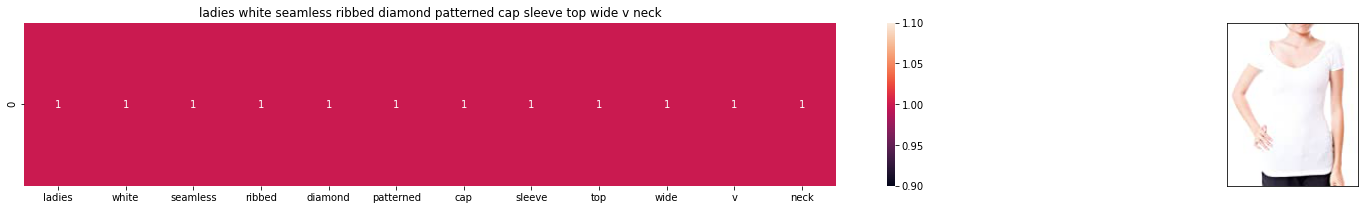

The amazon ID of the apparel is B00480IS52


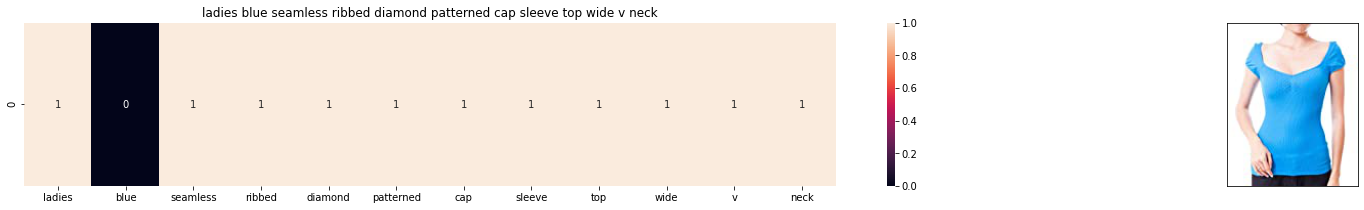

The amazon ID of the apparel is B00480IRPI


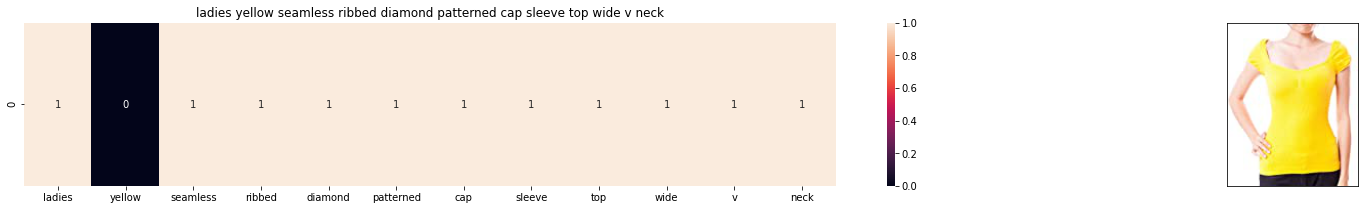

The amazon ID of the apparel is B00480IS3Y


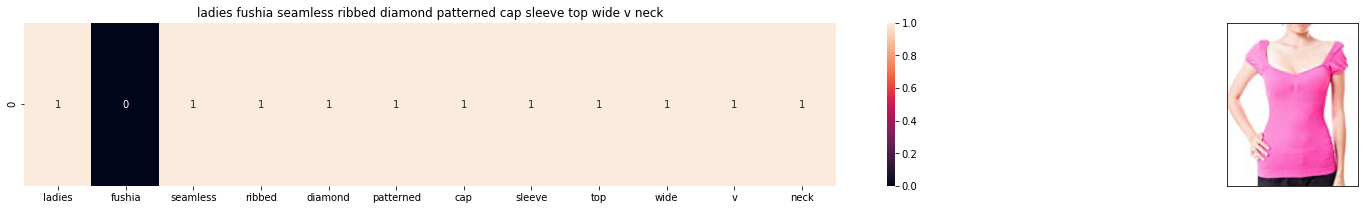

The amazon ID of the apparel is B00480GNQS


In [70]:
#doc_id, vectorization method = bag_of_words, dataset for modelling = data , cut_off = no. of recommendations
distance_similarity(17, data, 'bag_of_words', 4)

### TfidfVectorization based model

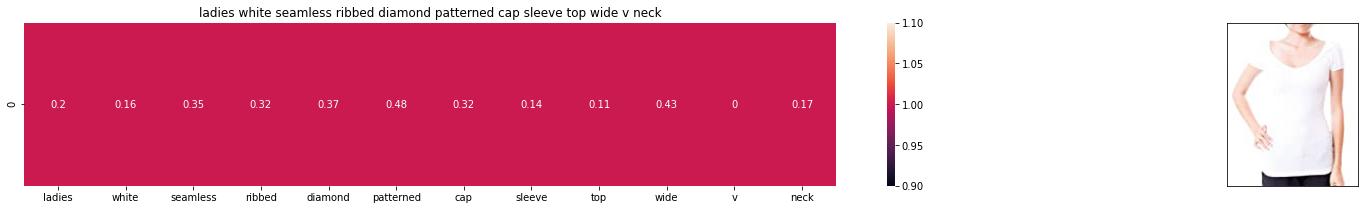

The amazon ID of the apparel is B00480IS52


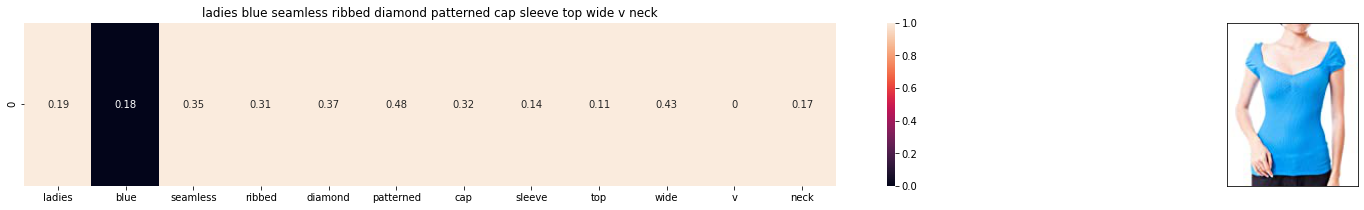

The amazon ID of the apparel is B00480IRPI


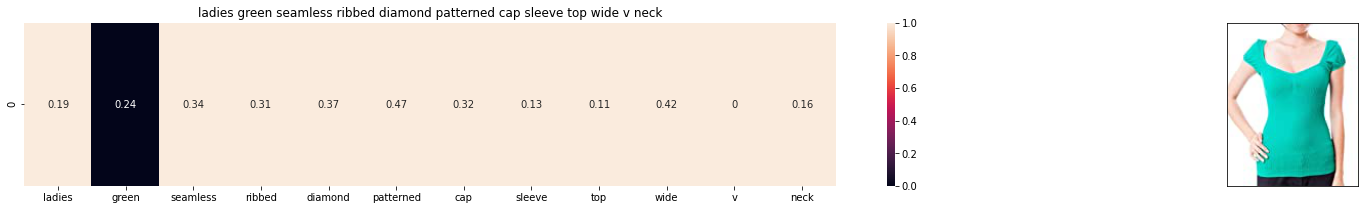

The amazon ID of the apparel is B00480IRZS


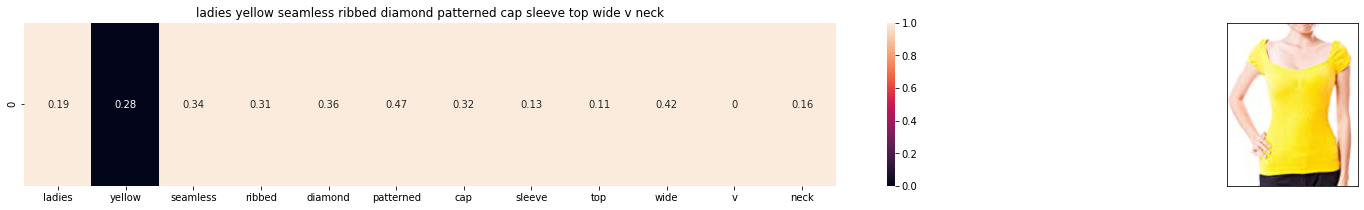

The amazon ID of the apparel is B00480IS3Y


In [71]:
distance_similarity(17, data, 'Tfidf', 4)

### IdfVectorization based model

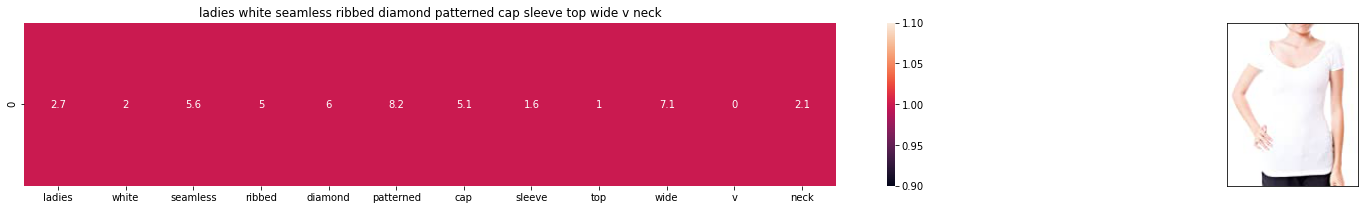

The amazon ID of the apparel is B00480IS52


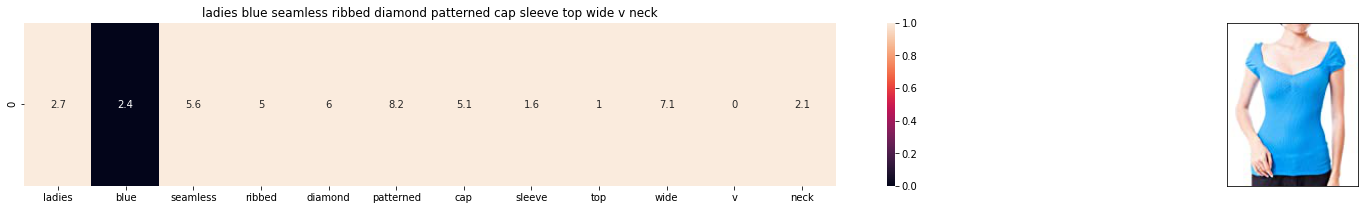

The amazon ID of the apparel is B00480IRPI


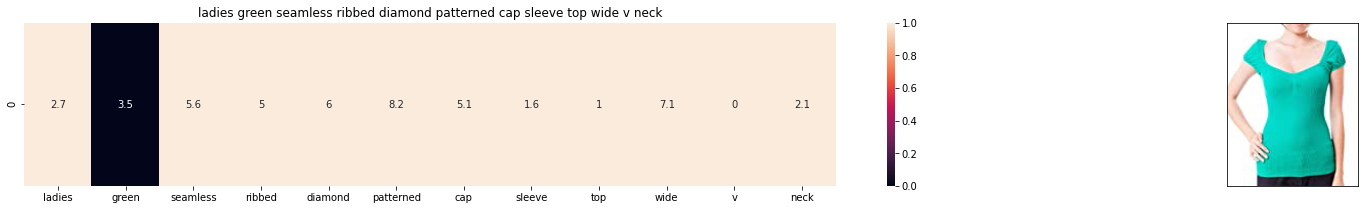

The amazon ID of the apparel is B00480IRZS


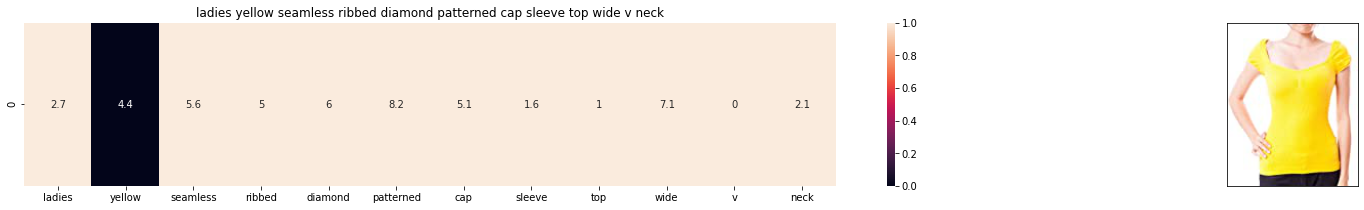

The amazon ID of the apparel is B00480IS3Y


In [79]:
distance_similarity(17, data, 'idf', 4)

## Semantic meaning based apparel similarity models

### Avg Word2Vec

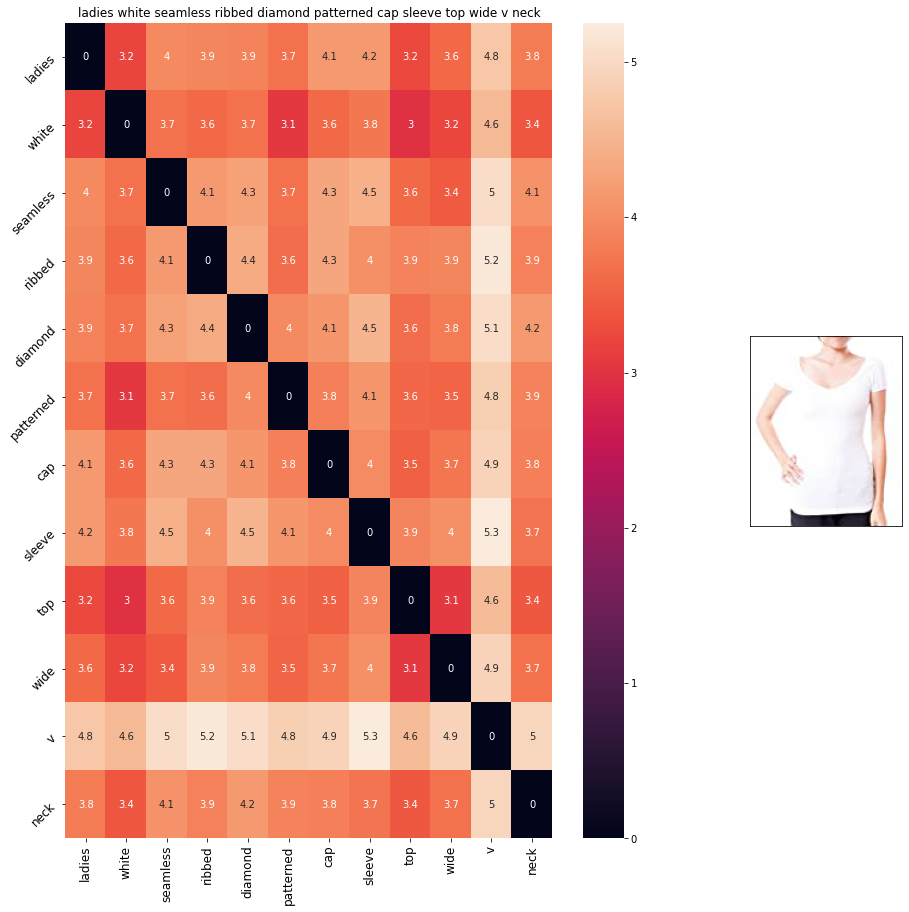

The amazon ID of the apparel is B00480IS52


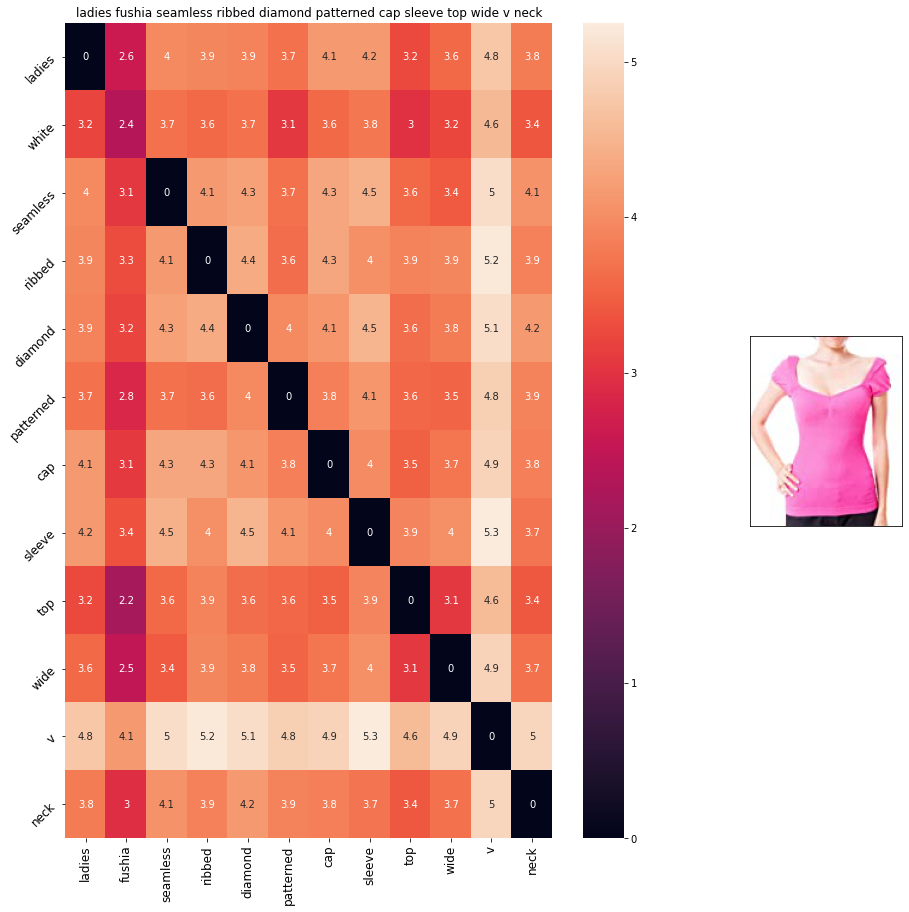

The amazon ID of the apparel is B00480GNQS


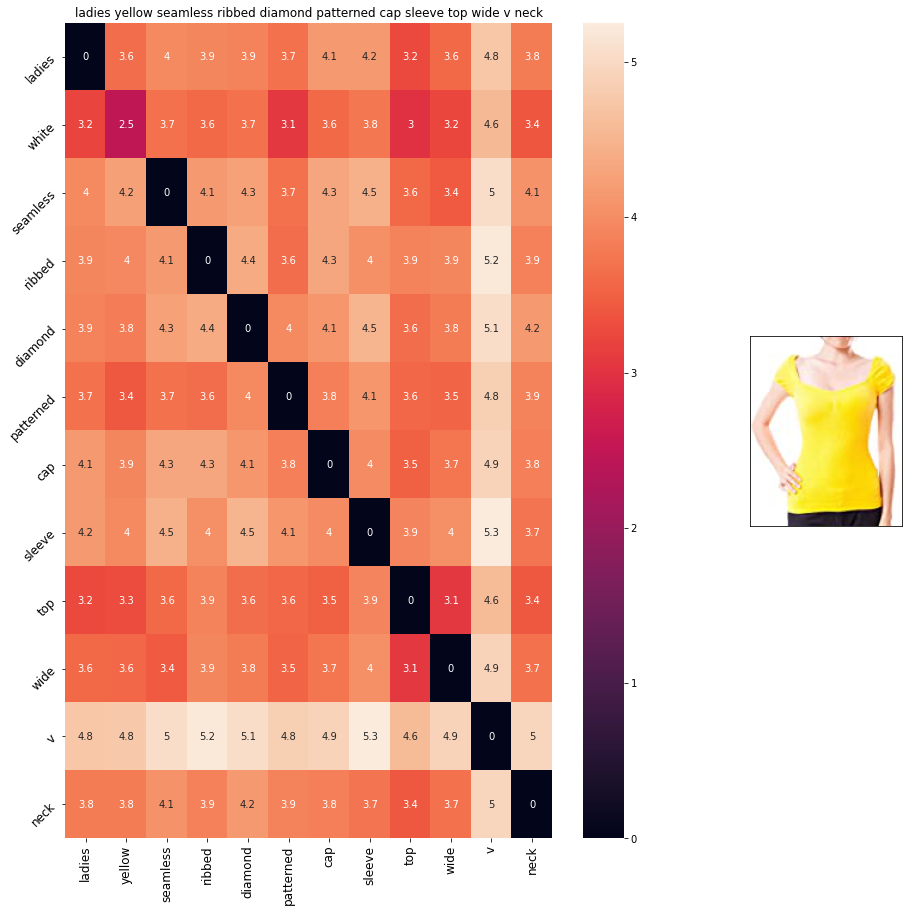

The amazon ID of the apparel is B00480IS3Y


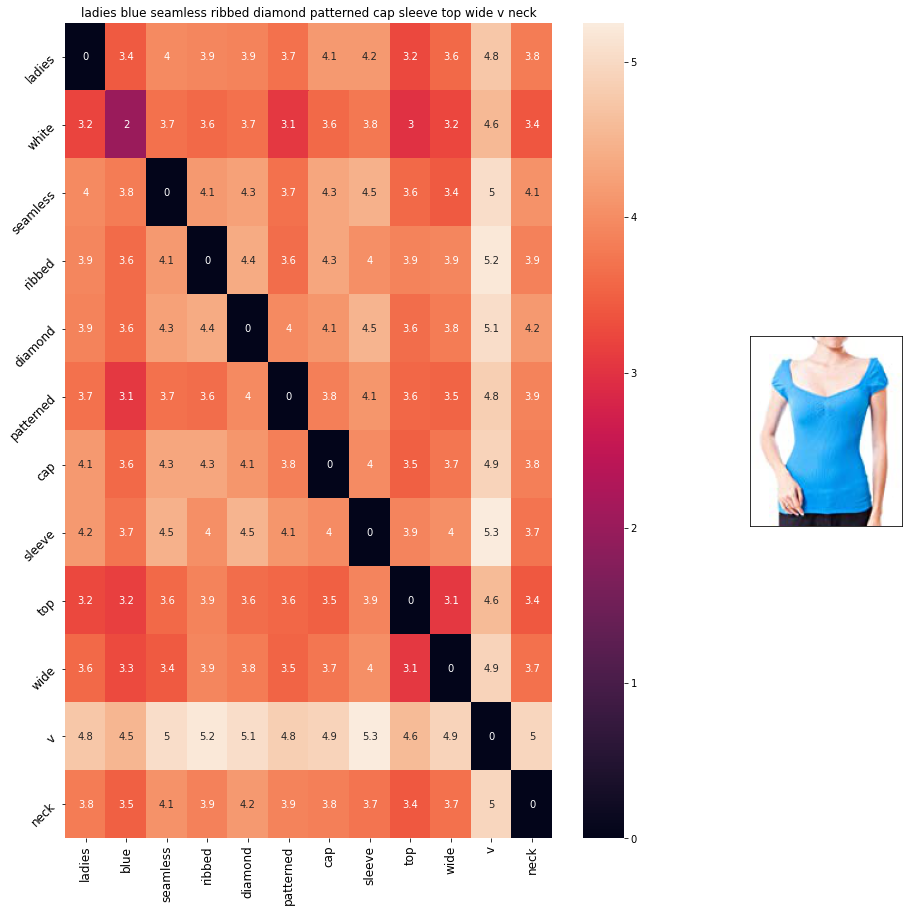

The amazon ID of the apparel is B00480IRPI


In [80]:
distance_similarity(17, data, 'avg', 4)

### Weighted Word2Vec

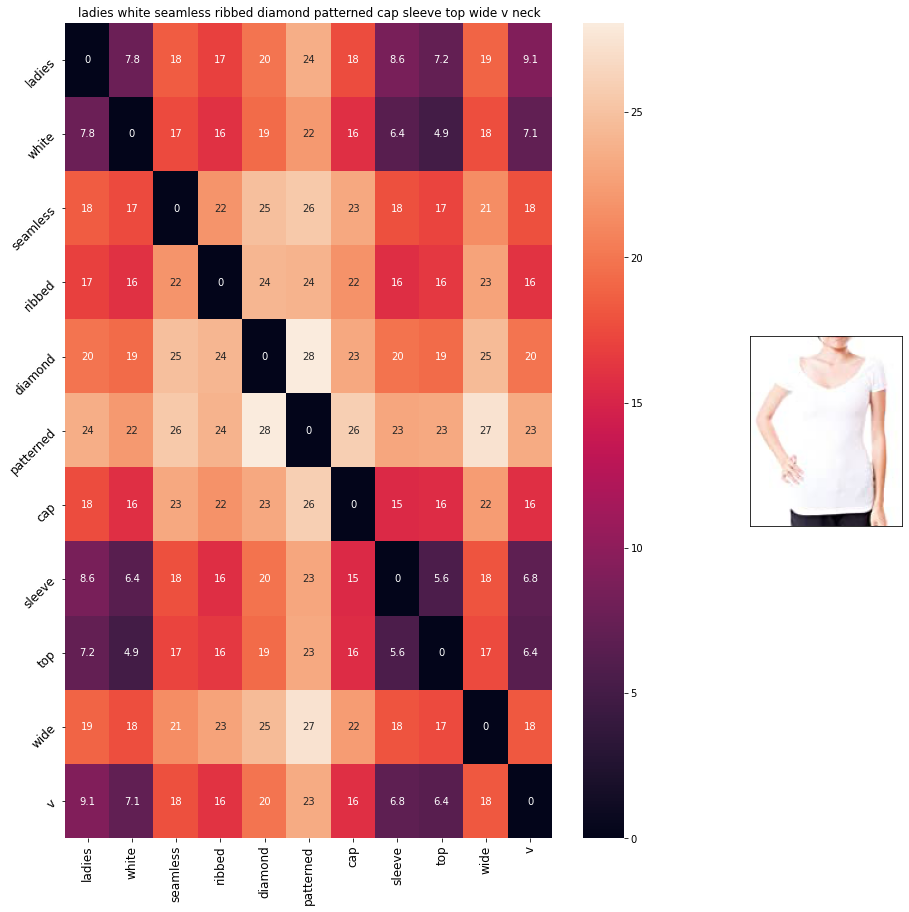

The amazon ID of the apparel is B00480IS52


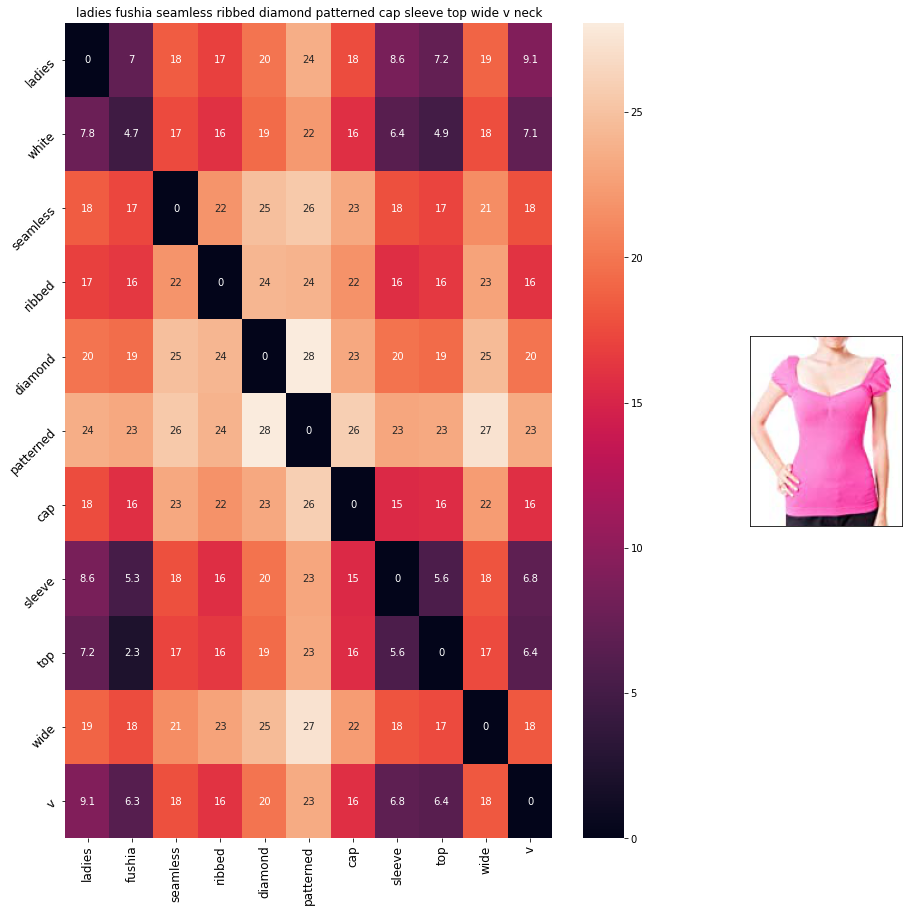

The amazon ID of the apparel is B00480GNQS


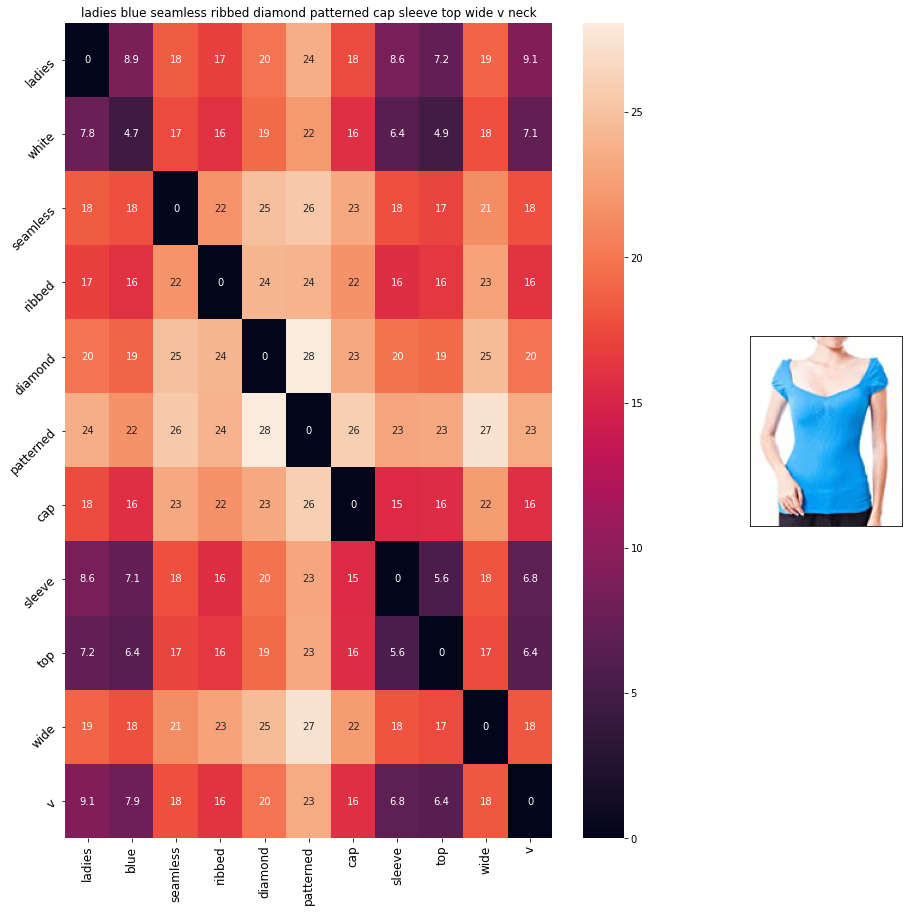

The amazon ID of the apparel is B00480IRPI


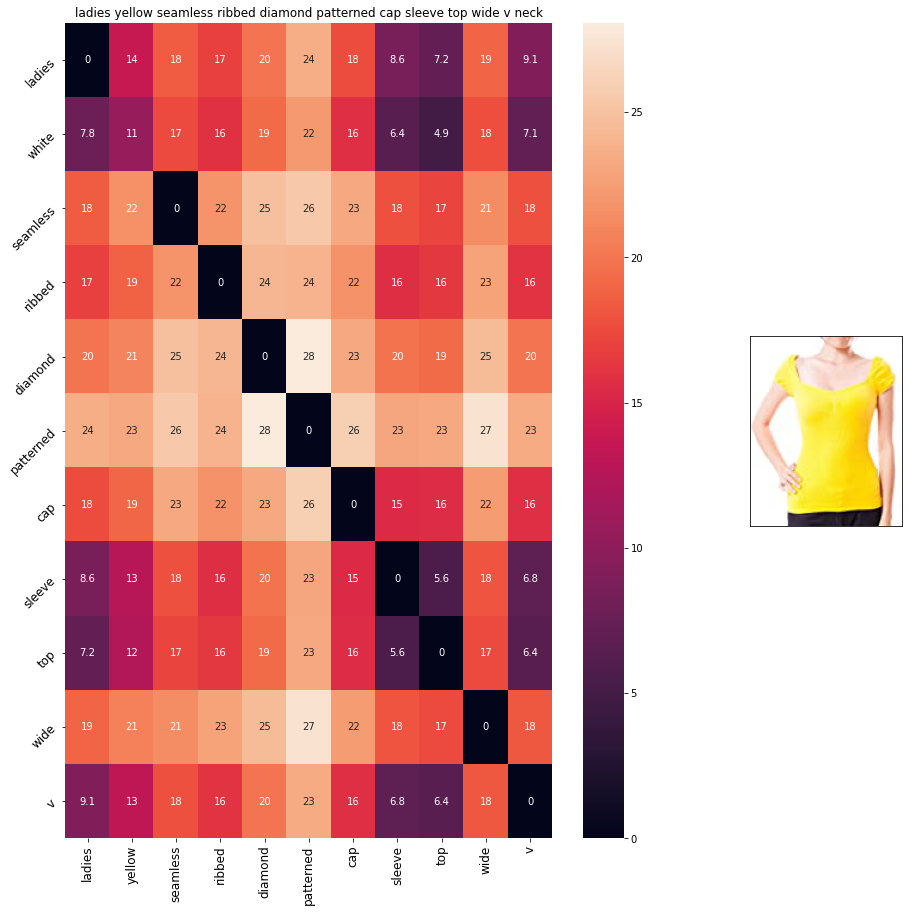

The amazon ID of the apparel is B00480IS3Y


In [81]:
distance_similarity(17, data, 'weighted', 4)

## Reflection


The purpose of the project is to make an product recommendation engine for Amazon. We are given simulated data that gives us various characteristics of the products on amazon. The recommendations are to be made based on these characteristics of the products and hence, we are building a content based fliter recommendation system. 

### Text preprocessing

After initial data analysis and data cleaning, we build our model using the 'title' feature which describes the various characteristices of the products in the form of strings. At first we need to preprocess the string of words that come under title feature inorder to use them to build vectors. These vector representation of strings are used to build a distance based similarity recommendation system. The steps of preprocessing are as follows:

1. First we make words in strings lower case in order to make the computer understand 'Amazon' and 'amazon' are the same words as the computer does not really understand the semantic meaning of words. 

2. We use Natural language processing toolkit to remove stopwords from our 'title' strings. Stopwords are most commonly used words present in every sentence like 'they' , 'hey', 'he' etc which do not add much to the semantic meaning of the sentences.  

3. We use Natural language processing to perform stemming  on our 'title' string. Stemming is a technique to reduce a base to its base form for example 'argument' becomes argu. The base form does not need to have any semantic meaning. Stemming did not work very well in our case hence we did not apply it.



### Methods of sentence to vector conversion

Now data['title'] is ready to be converted into vector form. These are methods of creating vector form for our string of words. They are as follows:

1. Bag of words:  Using CountVectorizer from sklearn we can convert a string of words to vectors. The CountVectorizer forms an array with features(columns) as words from the corpus of words from the input data and sentences as data points(rows). If the word exists in the sentence the feature value for that sentence becomes else 0. This method ends up creating a vector of 1's and 0's with dimensions equal to the number of words(feature) in our input text corpus. All vector representation of sentences are usually sparse arrays as they have very few words compared to the entire corpus of words.

2. Tfidf : Using TfidfVectorizer from sklearn we can convert a string of words to a vector. The TfidfVectorizer forms an array with features(columns) as words from the corpus of words present in the input text data and sentences as data points(rows). If a word exists in a sentence the Tfidf value for that feature in the sentence(data point) is term frequency of the word in that sentence multiplied by inverse document frequency. Term frequency (TF) is the number of times a word(feature) occurs in a sentence(data point) divided by the total number of words present in that sentence. If the word occurs more than once in a statement it has more term frequency/weightage. This makes sense as a higher weightage/magnitude of a feature in a vector will signify the higher importance of that word in the sentence. Inverse document frequency (IDF) is the log value of the total number of documents(sentences) in the input data divided by the number of documents(sentences) in which the feature(word) occurs. As log is an increasing function, the Inverse document log will have a higher value when the number of sentences in which the word(feature) occurs will be low (denominator), thus making the resulting IDF value(result of division) high. As the word occurs in less number of sentences(data points) as compared to commonly occurring words in sentences. It makes sense as we give more weightage/importance to a word occurring only in a few sentences as compared to a word commonly occurring in sentences, as this word might play a more important role in the meaning of the sentence.

3. IDF : We build an IdfVectorizer function in order to convert our sentence to a vector. IdfVectorizer forms an array with features(columns) as words from the corpus of words present in the text data and sentences as data points(rows). The Idf value is calculated in the same way as mentioned in the TfidfVectorizer model above. We only assign Idf value to the cells and ignore the TF values to avoid the bias of Termfrequency values towards sentences with less number of words present in them. The lower the number of words occurring in a statement the higher will the be term frequency value for a word because the denominator(total no of words in our sentence) will be lower(please refer to Tfidf description for formula).

4. Avg Word2Vec : We use Google's word2vec library which has vector representation of 3 million words in it. This library was created using neural network models to learn word association from a large corpus of texts. Each word has 300 dimension vector representation. The words having similar semantic meaning are assigned similar vector representation by the model. We make a function which gives us the vector representation of our sentences(data points) by adding all the vector representing the words in our sentence and dividing the resulting vector by the number of words in the sentence. The resulting 300 dimensions vector formed is an average vector representation of all the word in our sentence. This method is called as an Avg Word2Vec.

5. Weighted Word2Vec : We use google's word2vec library which has vector representation of 3 million words in it. This library was created using neural network models to learn word association from a large corpus of texts. Each vector (word) has 300 dimensions. The words having similar semantic meaning  are assigned similar vector representation by using a neural network model bascially placing them close to each other in a N(300) dimension space representation.



### Distance based similarity (Cosine)

Cosine distance is the measure of the angle between between two vectors in an N-dimensional space. N in our case is the number of features or the number of words present in our corpus of words formed from all the sentences in our data.
In distance based similarity recommendations, we use Cosine distance as a metric for distance measure when the magnitude of the vectors does not matter. Let us understand this with an example, suppose we are working with text data represented by word counts. We make an assumption that when a word for example 'physics' occurs more frequently in a given sentence 1 than it does in a given sentence 2, the magnitude of the vector tells us that sentence 1 is more similar to the topic of physics. However, it could be the case that we are working with sentences of unequal lengths. Physics probably occurred more in sentence 1 because the sentence is longer as compared to sentence 2. Cosine similarity corrects this bias. Text data is the most typical example for when to use this metric, you would want to apply cosine similarity for cases where the features weights might be larger without meaning anything different. If we would use Euclidean distance instead of Cosine distance the magnitude of the distance between the vectors of sentence 1 and sentence 2 would make it seem they are far apart. This is the case because Euclidean distance is affected by the magnitude of the vector.

To summarize if we plot in an N-dimensional space, where each dimension represents a word in the sentence, the cosine similarity captures the the angle between the sentences(vectors) and not the magnitude of distance between them. If we need the magnitude, we should compute the Euclidean distance instead.

### Distance based similarity (Euclidean)

In case of average Word2Vec model each word is assigned a 300 dimension vector based on its semantic meaning. The words are preassigned these vectors and features by Google and have nothing to do with the word corpus of our sentences unlike the other vectorization methods. As the vector cell magnitude does not represent the presence of a word in a sentence, the magnitude of the vector will matter in case of average word2vec. It makes more sense to use Euclidean distance instead of Cosine distance to make distance based similarity recommendations when magnitude of the vector plays a role in measuring distance between the vectors (refer to the Cosine distance description above).

## Conclusion & Improvements

1. We are still getting same products as recommendation even after removing products with duplicate descriptions, this happens because of different words used in description of similar products. Inorder to remove these duplicates we can use image processing techniques on downloaded images of products and remove the duplicate images.

2. Word2Vec vectorization does not work well in our case because of the null vectors assigned to unique words not present in the Google's word to vec dictionary such as specific brand names, unique product nitty-gritties etc. In order to make Word2Vec vectorization give more relevant results we will need to make our own Word2Vec dictionary using the corpus of words present in the relevant features of the dataset we model. 

3. Seeing our results we cannot determine which vectorization model is giving us better results amongst bag of words, Tfidf and idf vectorized models. To find out which model is better we would have to first live test our recommendation models. We would divide our customers into random test groups of equal sizes and live test a model on each group. Second step would be to collect various response parameters or business parameters such as purchase conversion rate of recommendations, recommendation selection rate etc. Third step would be to perform multivariate A/B testing using these parameters after collecting sufficiently large data to select the best performing model.
 